# Attention tokens

While exploring some other behaviour I noticed that different heads consistently represent inputs using a small set of tokens if you unembed the components of attention heads. I still need to run more comprehensive tests, but so far this seems to hold for any arbitrary inputs.:w
 I think this is likely heavily influenced by positional encodings.

Each head appears to use it's attention tokens to chunk inputs in ways specific to that head. Some heads compress inputs into a small number attention tokens - as few as 3-4 for 16 token inputs. Others expand and others linearly track or double with input. My intuition is that this represents how heads structurally decompose inputs to represent meaning for their specific tasks and so provides a means for classifying heads.

Macro patterns across heads also emerge - particularly when considering the element-wise product of q and k. The plot on the left shows a t-SNE plot for the embeddings of the element-wise attention tokens - colors representing layers. The plot on the right shows how attention tokens are shared between all pairs of attention heads.

<div style="display: flex; justify-content: center;">
    <img src="./imdb-tsne.png" alt="Image 1" style="width: 45%; margin-right: 10px;">
    <img src="./shared-token_imdb.png" alt="Image 2" style="width: 45%;">
</div>

In [1]:
import torch
from transformer_lens import HookedTransformer 
import plotly.io as pio
import matplotlib.pyplot as plt

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


The plot below allows you to explore how attention tokens are generated. Note, the colourscale is based on the order in which the attention tokens are discovered during generation meaning brighter colours represent tokens generated later in the process. This means that colours don't represent absolute token values and instead more of a relative position within the generation.

In [2]:
prompt = "The next sentence is false. The previous sentence is true."
cache = run_prompts(model, prompt)

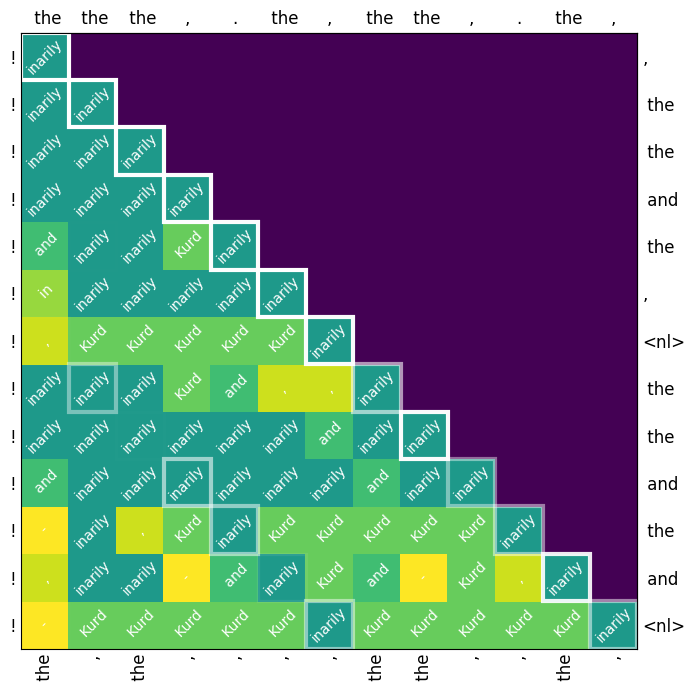

In [3]:
l, h = 0, 1
attn_data = calculate_attns(cache, l, h)
plot = plot_attn(model, attn_data)

figure(
    plot, 
    title=f"Attention tokens for {l}.{h}", 
    description="""
    Each cell represents the element-wise product of the Q and K components of the attention head. Colors increase in brightness based on the order in which the attention tokens were discovered in the raw input.
    Axis clockwise from top: query, key, value, and input tokens.
    Attention scores for the final position are overlaid as white borders.
    """,
    footer=f'Input: {prompt}',
)

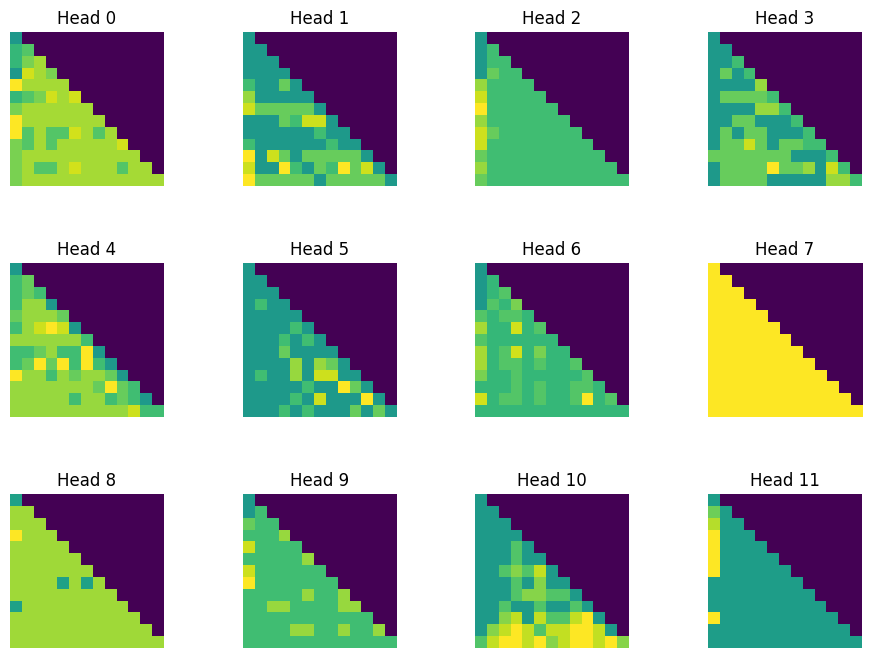

In [4]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, l, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(
    plot, 
    title=f"Attention token plots for each head in layer {l}",
    description="""
    Note that the colors are relative and don't represent the same atttention token across heads. 
    Instead the patterns show how each head uses the tokens within its vocabulary set.
    """,
    footer=f'Input: {prompt}',
)

To get a sense of how attention tokens are generated I want to test over a reasonably large and varied inputs. For the time being I'm using the imdb dataset because it contains a wide variety of natural language from multiple authors and is relatively small.

The code below extracts 3 random prompts from the dataset and uses them as the input into the model. We then use the cached activations to generate a dataset of attention tokens for each component across each head. The length of each prompt is capped at 16 tokens.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")
inputs = random.choices(dataset["train"]["text"], k=3)
inputs = model.to_string(model.to_tokens(inputs)[:, :16])
cache = run_prompts(model, *inputs)

data = generate(cache)
df = to_df(data)
df.to_csv("imdb_example.csv", index=False)
df

Generating the attention token dataset from activations can take a while depending on how many inputs you have and how long they are. To save time, I've pre-generated a dataset of 32 prompts with a token length of 32 from the imdb dataset.

In [5]:
df = load('../data/32x32_attn.csv')
df

,layer,head,Input token,attn,hp,q,k,v
0,0.0,0.0,50256.0,1.000000,357.0,11.0,11.0,262.0
1,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
2509051,11.0,11.0,379.0,0.002832,47992.0,10473.0,47992.0,2887.0
2509052,11.0,11.0,379.0,0.002169,47992.0,10473.0,47992.0,2887.0
2509053,11.0,11.0,379.0,0.004394,47992.0,10473.0,47992.0,2887.0
2509054,11.0,11.0,379.0,0.016218,23712.0,10473.0,47992.0,2887.0


While it's interesting to look at the patterns that emerge in the token plots, and I think it can be useful for interpreting head behaviour (see below), it doesn't help to understand any macro patterns that may exist across the model heads.

Calculating fequencies of each token shows a dramatic compaction down to ~1200 tokens for the element-wise product and ~10000 for the Q and K components and ~25000 for V. These numbers seem relatively invariant to actual token input and length - see random token experiments below for more details.

In [6]:
token_counts = token_freq_data(model, df, 4, (144, 32, 32, 32))
q_token_counts = token_freq_data(model, df, 5, (144, 32, 32, 32))
k_token_counts = token_freq_data(model, df, 6, (144, 32, 32, 32))
v_token_counts = token_freq_data(model, df, 7, (144, 32, 32, 32))
token_counts

,Head,Token,Frequency,Token str,Rank
0,0,11,1325,",",4.0
1,0,12,461,-,6.0
2,0,198,82,\n,12.0
3,0,287,94,in,11.0
4,0,290,328,and,7.0
...,...,...,...,...,...
1207,76,9228,223,burgh,5.0
1208,76,22150,292,ultz,4.0
1209,76,23712,3923,eday,2.0
1210,76,30044,407,Jude,3.0


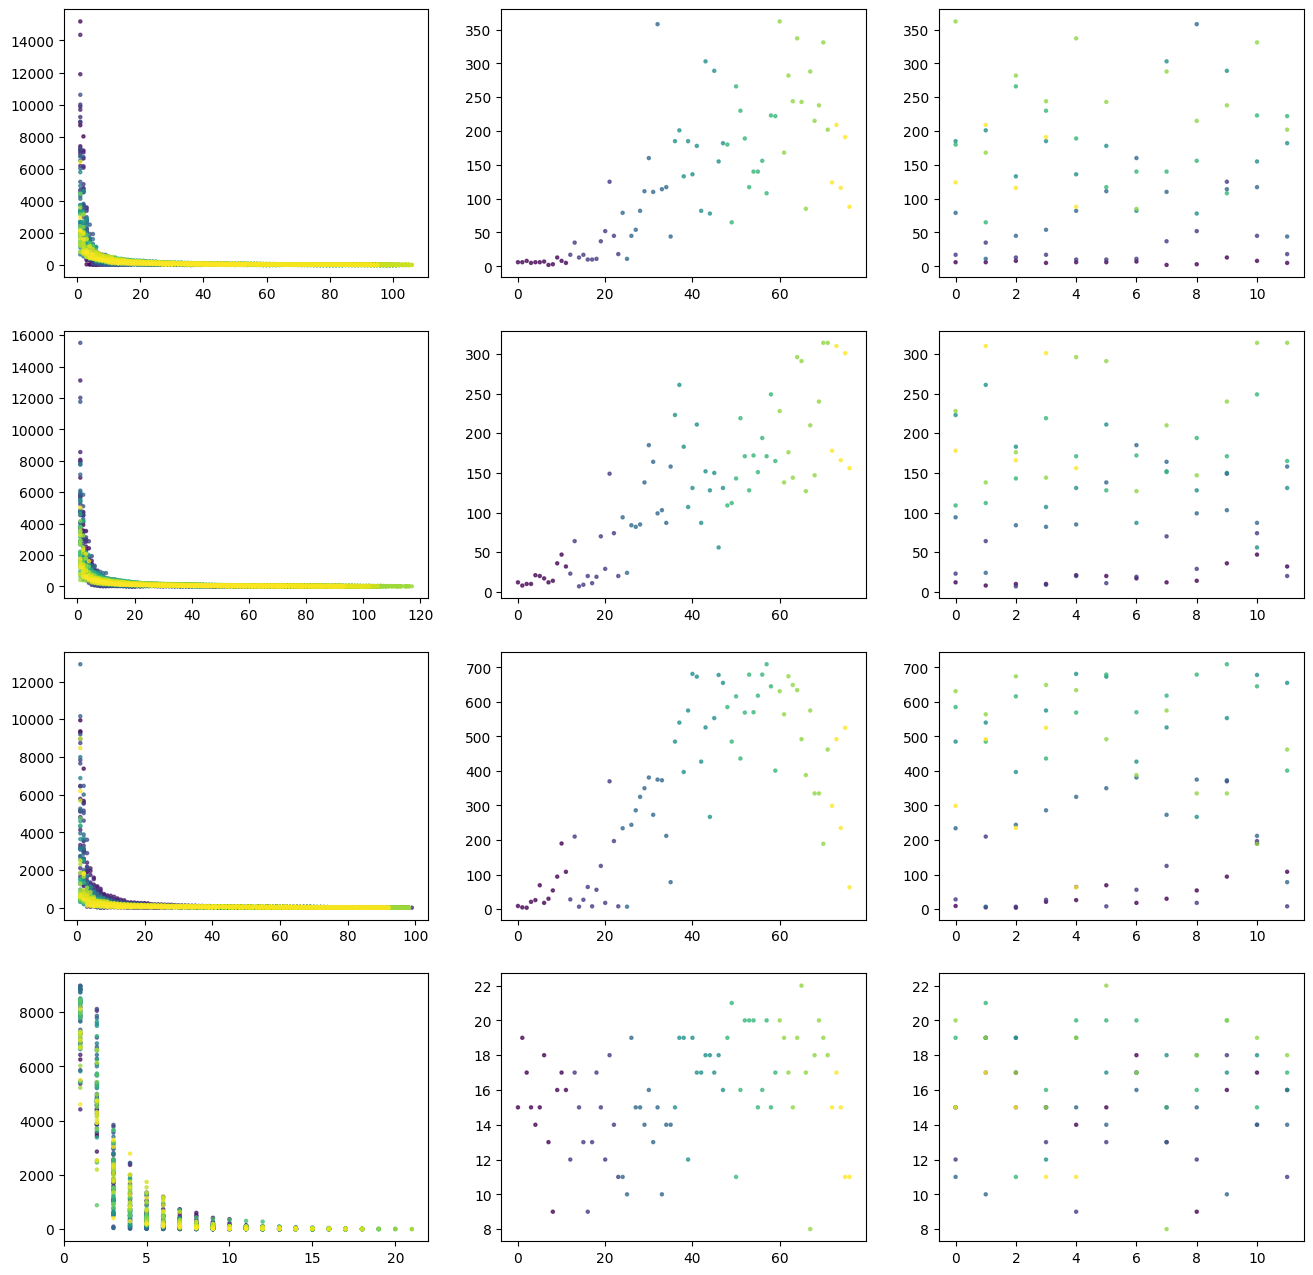

In [7]:
fig, axs = plt.subplots(4, 3, figsize=(16, 16))
plot_token_frequencies(model, q_token_counts, ax=axs[0][0])
plot_unique_tokens_by_head(model, q_token_counts, ax=axs[0][1])
plot_unique_tokens_by_layer_head(model, q_token_counts, ax=axs[0][2])
plot_token_frequencies(model, k_token_counts, ax=axs[1][0])
plot_unique_tokens_by_head(model, k_token_counts, ax=axs[1][1])
plot_unique_tokens_by_layer_head(model, k_token_counts, ax=axs[1][2])
plot_token_frequencies(model, v_token_counts, ax=axs[2][0])
plot_unique_tokens_by_head(model, v_token_counts, ax=axs[2][1])
plot_unique_tokens_by_layer_head(model, v_token_counts, ax=axs[2][2])
plot_token_frequencies(model, token_counts, ax=axs[3][0])
plot_unique_tokens_by_head(model, token_counts, ax=axs[3][1])
plot_unique_tokens_by_layer_head(model, token_counts, ax=axs[3][2])
figure(
    fig,
    title="Token frequencies",
    description="""
    From left to right: token frequencies, attention token count by head, and attention token count by layer.
    From top to bottom: query, key, value, and element-wise attention tokens.
    Colors represent layer index.
    """,
    footer="IMDB dataset",
)

I've tried various dimensionality reduction techniques, but t-SNE offers by far the most striking visualizations. The plots are unusualy for t-SNE and suggest a highly stucutured dataset, but this is generated from randomly selected snippets natural language.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


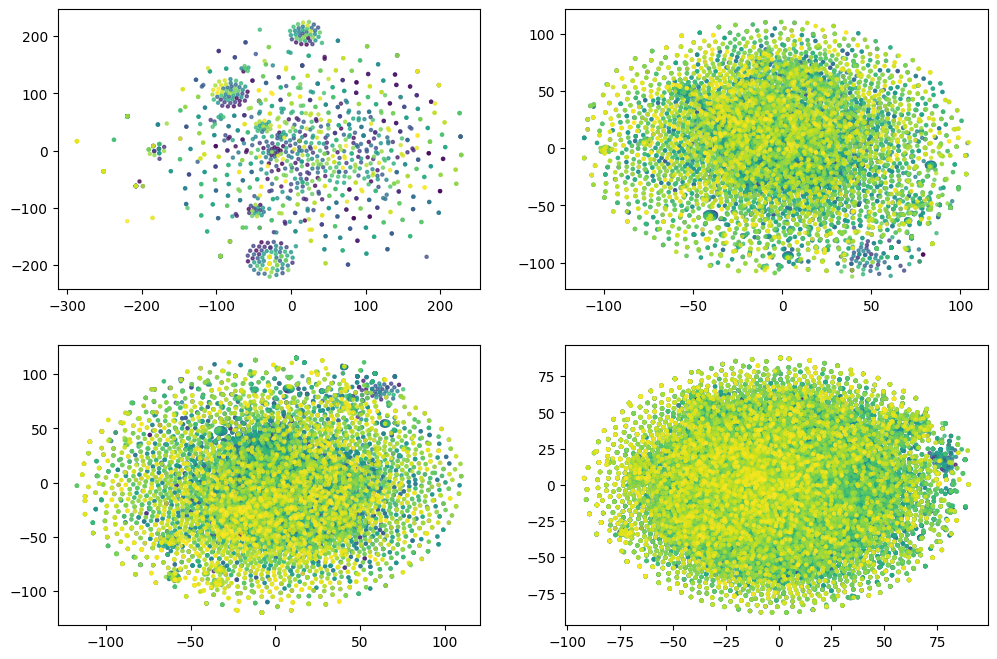

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts, 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, q_token_counts, 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, k_token_counts, 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, v_token_counts, 'TSNE', ax=axs[1][1])

figure(
    fig,
    title="t-SNE for attention token embeddings",
    description="""
    t-SNE representation of the embeddings of the element-wise, query, key, and value attention tokens from top clockwise.
    Colours represent the layer index.
    """,
    footer="IMDB dataset",
)

Calculating token frequencies shows that patterns exist in how attention tokens are shared between heads - at least one token is shared between every head pair and at most 4 are shared. This forms a pattern that could point to how heads collaborate under different tasks

In [9]:
hp = shared_tokens(df)
hp.sort_values('Shared Tokens', ascending=False)

,Subgroup 1,Subgroup 2,Shared Tokens,Tokens
7928,,²,4,"290.0,11.0,198.0,262.0"
469,D,,4,"257.0,290.0,11.0,262.0"
2555,V,,4,"649.0,290.0,11.0,262.0"
7312,,²,4,"290.0,11.0,198.0,262.0"
3027,Z,,4,"15961.0,257.0,11.0,262.0"
...,...,...,...,...
7364,,©,1,11.0
7365,,ª,1,11.0
7366,,«,1,11.0
7368,,­,1,11.0


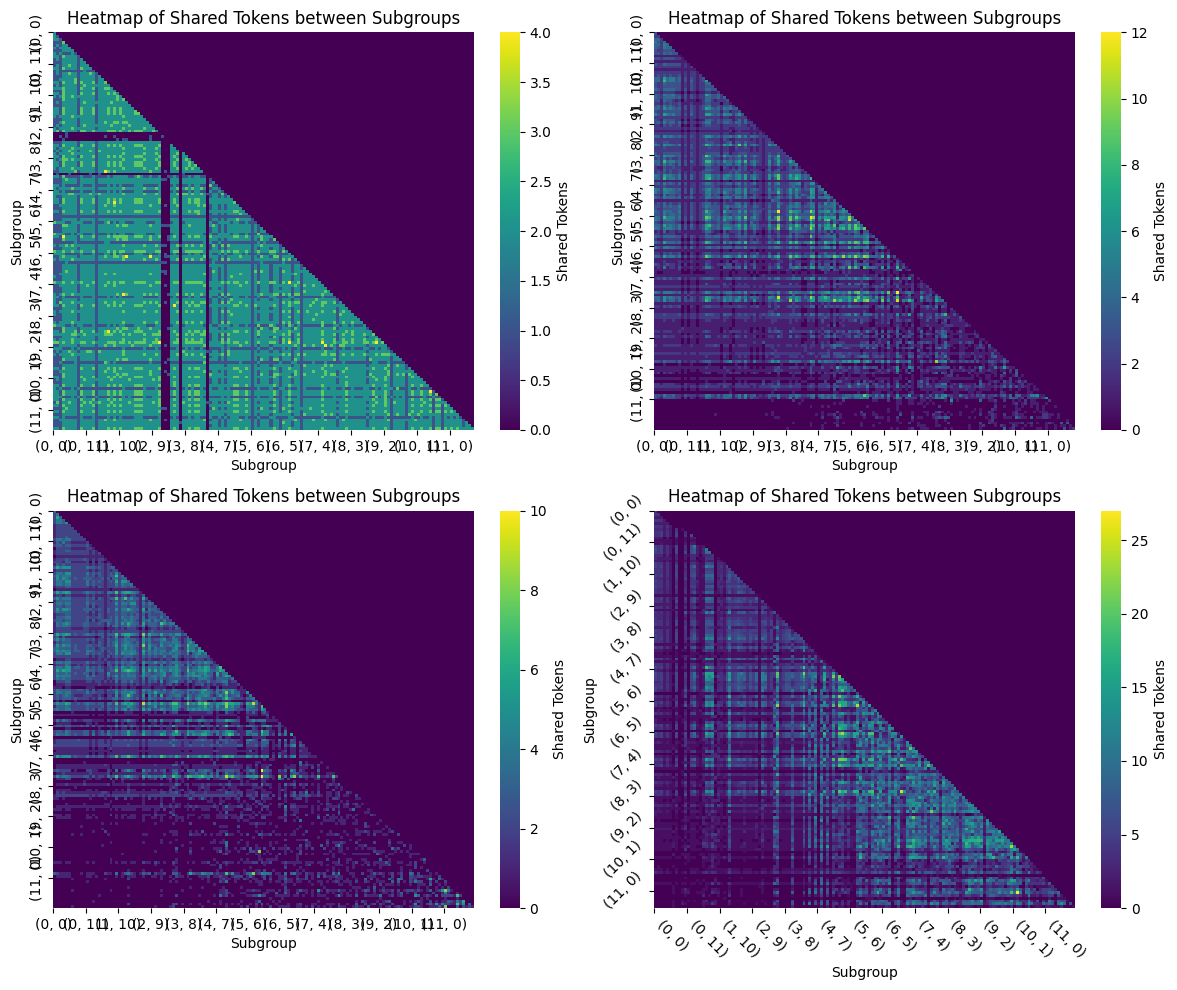

In [10]:
q = shared_tokens(df, 'q')
k = shared_tokens(df, 'k')
v = shared_tokens(df, 'v')

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
visualize_shared_tokens(hp, ax=axs[0][0])
visualize_shared_tokens(q, ax=axs[0][1])
visualize_shared_tokens(k, ax=axs[1][0])
visualize_shared_tokens(v, ax=axs[1][1])

figure(
    fig,
    title="Shared tokens",
    description="""
    Heatmap of how tokens are shared between pairs of heads for element-wise, query, key, and value tokens from top clockwise.
    """,
    footer="IMDB dataset",
)

### Random inputs

Testing with random token inputs provides some insights into how the heads behave in a "default" state. It also makes it easy to change the input length without worrying about being distracted by how that affects the semantic/grammatical structure of the input.

Here are the heads of the first layer using a single random token repeated 62 times.

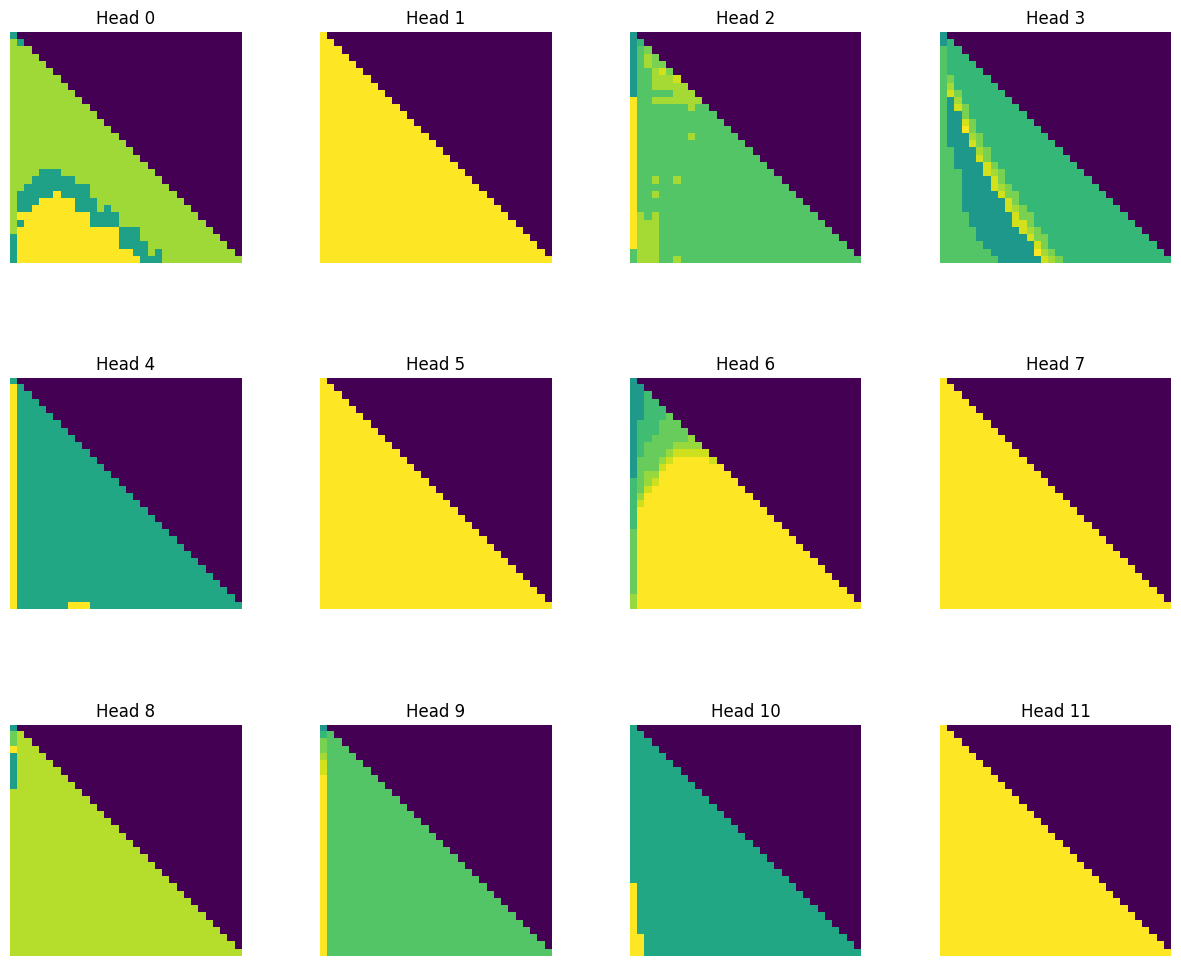

In [11]:
token = random.randint(0, 50257)
prompt = torch.full((1, 31), token)
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random single repeating token")

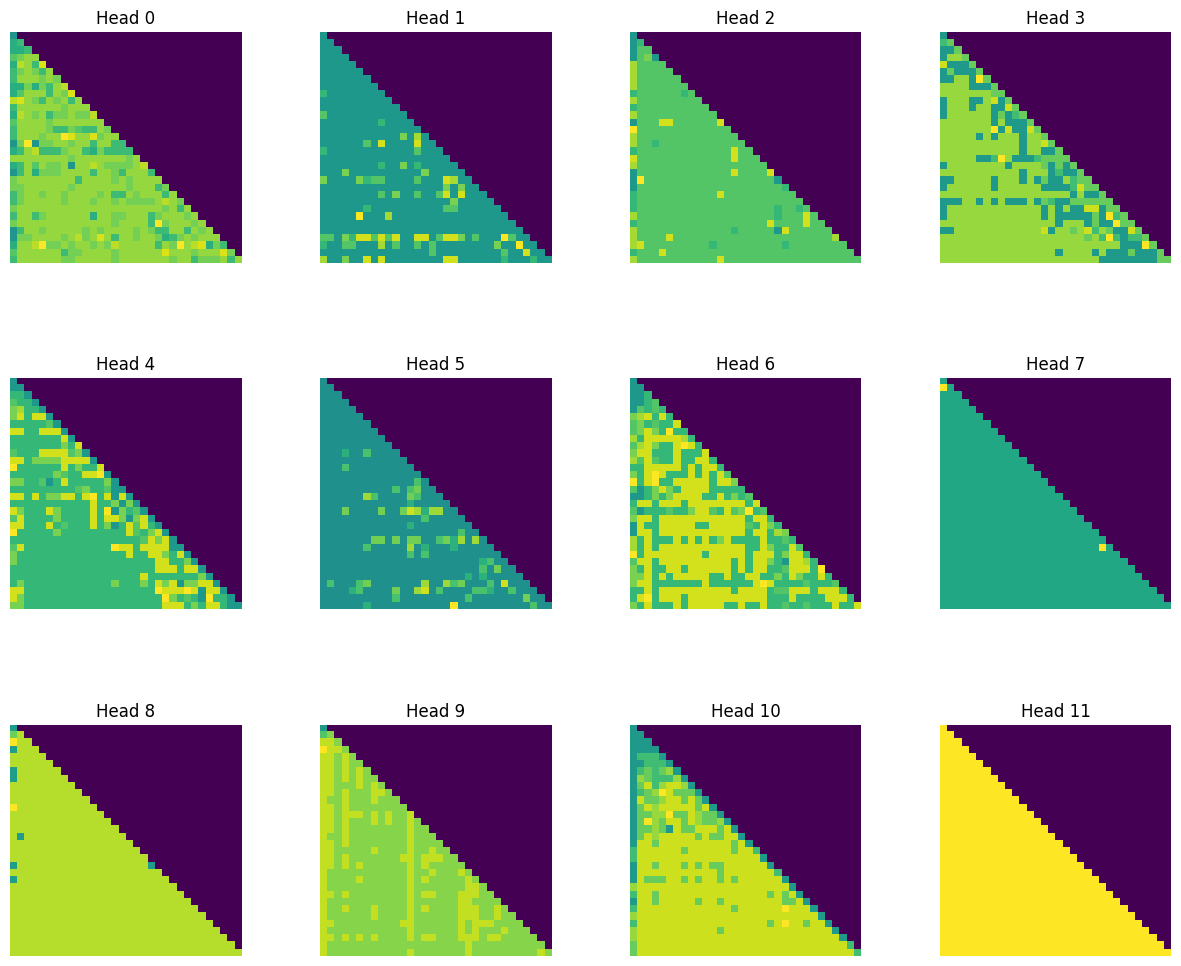

In [12]:
prompt = torch.randint(0, 50257, (1, 31))
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random tokens")

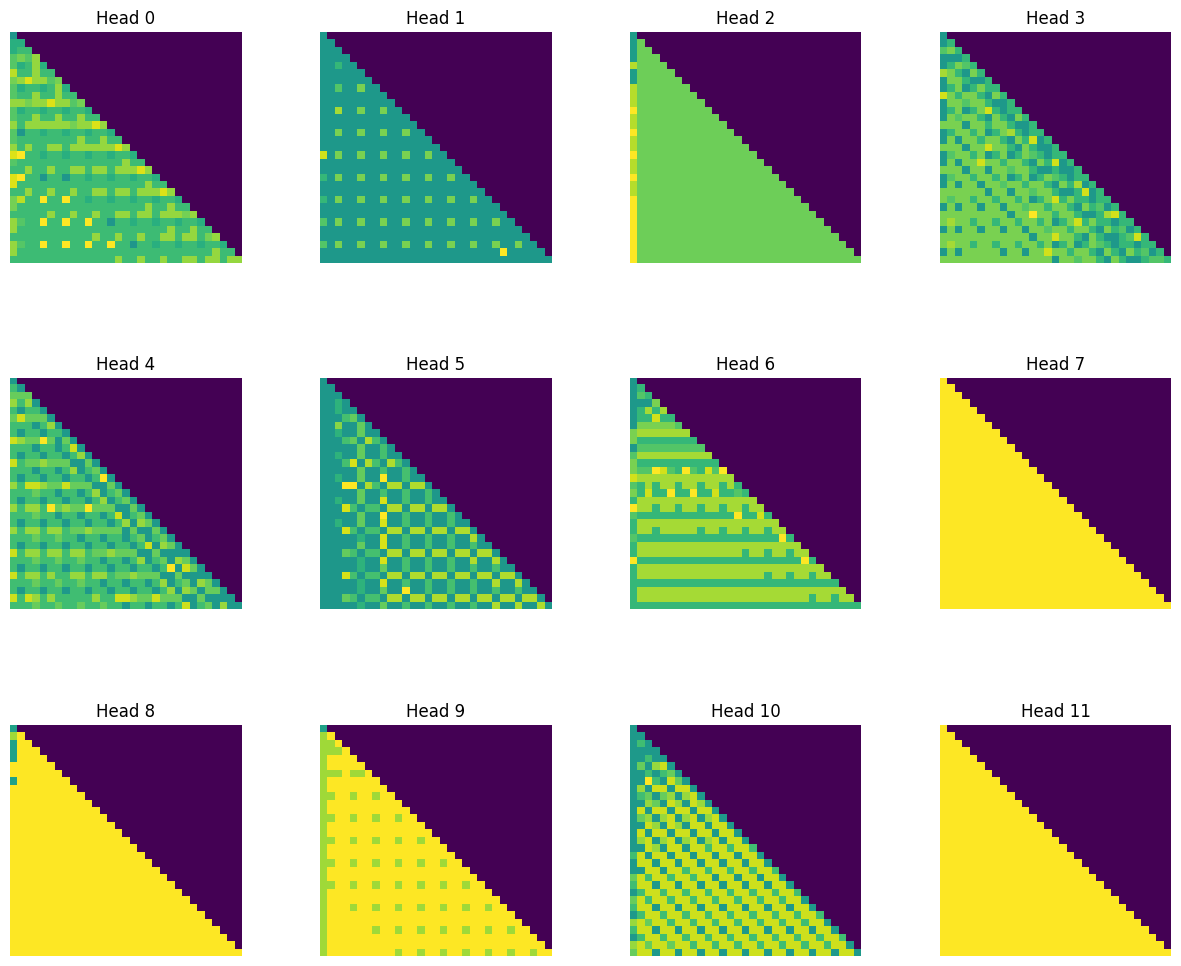

In [13]:
prompt = torch.randint(0, 50257, (1, 3)).repeat(1, 10)
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random repeating 3-seq token")

While the specific patterns change, if you run this multiple times you can see clear motifs emerge that identify specific heads. You can also see broad similarities in the patterns produced from the same head across inputs.

Again, to get a better idea of how the attention tokens a distributed across heads we can look at the t-SNE plots and shared tokens. The t-SNE plots show similar patterns for the element-wise tokens, but much simpler more structured outputs for q, k and v tokens. This makes sense given the constrained input/output of the random sequence.

In [14]:
df = load('../data/32x32-random_attn.csv')
token_counts = token_freq_data(model, df, 4, (144, 32, 32, 32))
q_token_counts = token_freq_data(model, df, 5, (144, 32, 32, 32))
k_token_counts = token_freq_data(model, df, 6, (144, 32, 32, 32))
v_token_counts = token_freq_data(model, df, 7, (144, 32, 32, 32))
v_token_counts

,Head,Token,Frequency,Token str,Rank
0,0,11,62,",",2.0
1,0,262,31,the,3.0
2,0,287,16743,in,1.0
3,1,11,31,",",3.0
4,1,262,15701,the,1.0
...,...,...,...,...,...
1252,152,41744,10,antid,5.0
1253,152,43617,15456,Whit,1.0
1254,152,46800,855,TMZ,2.0
1255,153,16100,4,retty,2.0


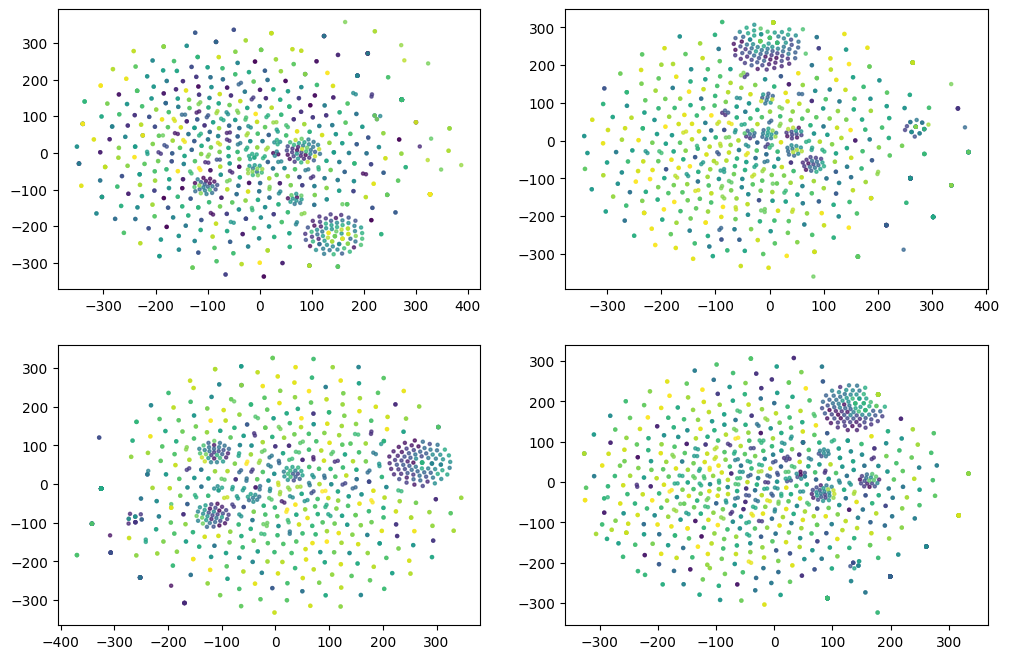

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts, 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, q_token_counts, 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, k_token_counts, 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, v_token_counts, 'TSNE', ax=axs[1][1])

figure(
    fig,
    title="t-SNE for attention token embeddings",
    description="""
    t-SNE representation of the embeddings of the element-wise, query, key, and value attention tokens from top clockwise.
    Colours represent the layer index.
    """,
    footer="Random sequence dataset",
)

The shared token plots are similar to the natural language examples, but there's less structure and a slight hyperbolic nature to some regions.

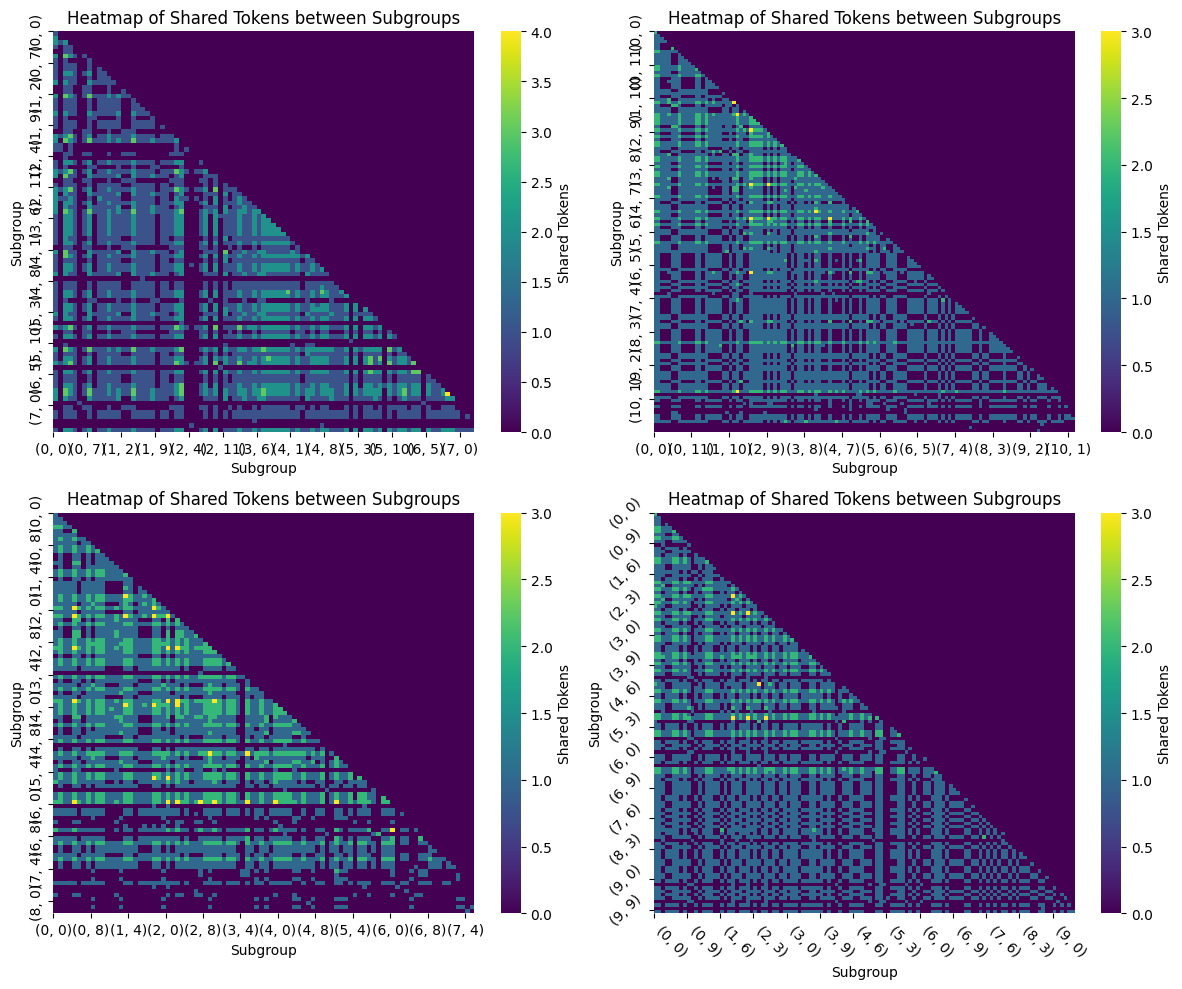

In [16]:
hp = shared_tokens(df)
q = shared_tokens(df, 'q')
k = shared_tokens(df, 'k')
v = shared_tokens(df, 'v')

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
visualize_shared_tokens(hp, ax=axs[0][0])
visualize_shared_tokens(q, ax=axs[0][1])
visualize_shared_tokens(k, ax=axs[1][0])
visualize_shared_tokens(v, ax=axs[1][1])

figure(
    fig,
    title="Shared tokens",
    description="""
    Heatmap of how tokens are shared between pairs of heads for element-wise, query, key, and value tokens from top clockwise.
    """,
    footer="Random sequence dataset",
)

## Specific head analysis

Random repeating sequences provides the clearest interpretability without being devoid of structure so I'm starting there. Understanding how heads evolve based on changing predictable sequences is likely to provide more general insights, but it's worth noting again the risk of these toy inputs not translating to more realistic language.

To provide some structure to the work I plan to evaluate the patterns using this approach:
- Take an input sequence (S) and convert it into a sequence of attention tokens (A)
- Given the next token (t) generate a new sequence of attention tokens using S + t
- Analyse the invariances and symmetries implied by how different sequences produce different attention tokens

### 0.0